In [1]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
class MyDataset(Dataset):
    def __init__(self,
                 images_folder,
                 transform=None,
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.images_folder = images_folder

        self.transform = transform if transform else \
            A.Compose(
                [
                    ToTensorV2(),
                ]
            )
        self.model_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

        self.images_paths = []
        self._read_images_names()

    def _read_images_names(self):
        for root, dirs, files in os.walk(self.images_folder):
            for image_name in files:
                img_path = os.path.join(root, image_name)

                _, ext = os.path.splitext(img_path)
                if ext not in ['.png', '.jpg', '.jpeg']:
                    continue

                self.images_paths.append(img_path)

    def __len__(self):
        return len(self.images_paths)
    
    def get_original_image(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image

    def __getitem__(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transform(image=image)["image"]
        image = self.model_transform(image)

        return image.float()

In [3]:
my_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds1")

In [4]:
len(my_dataset)

70000

In [5]:
class EmbeddingsExtractor(pl.LightningModule):

    def __init__(self):
        super(EmbeddingsExtractor, self).__init__()

        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
        )

        for name, param in self.model.named_parameters():
            # if "fc" in name or "layer4" in name or "layer3" in name:
            #     continue
            param.requires_grad = False

        # self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def get_embedings(self, dataset):
        dataloader = DataLoader(dataset, batch_size=16)
        self.eval()
        embeds = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(self.device)
                outputs = self(batch)
                embeds.append(outputs)
        return torch.cat(embeds)

In [6]:
my_dataset_1, my_dataset_2 = torch.utils.data.Subset(
    my_dataset, 
    range(
        len(my_dataset) // 2)
    ), \
    torch.utils.data.Subset(
        my_dataset, 
        range(len(my_dataset) // 2, 
        len(my_dataset))
    )

In [7]:
import torch.utils
import torch.utils.data


def get_embeds_example(dataset, extractor, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    subsample_size = min(subsample_size, len(dataset))
    idxs = np.random.choice(range(len(dataset)), subsample_size, replace=False)
    subset = torch.utils.data.Subset(dataset, idxs)
    
    embeds = extractor.get_embedings(subset)
    return embeds

In [8]:
extractor = EmbeddingsExtractor()

In [9]:
get_embeds_example(my_dataset, extractor, 10).shape

torch.Size([10, 512])

In [10]:
embeds1, embeds2 = get_embeds_example(my_dataset_1, extractor, random_seed=42), get_embeds_example(my_dataset_2, extractor, random_seed=69)

In [11]:
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error as mse
from itertools import product

def _mean_similarity(emb1, emb2):

    sim_sum = 0
    for el1 in emb1:
        for el2 in emb2:
            sim_sum += np.dot(el1, el2) / (np.linalg.norm(el1) * np.linalg.norm(el2))
    
    return sim_sum / len(emb1) / len(emb2)


def embeds_list_similarity(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)

    return np.mean(_mean_similarity(emb1, emb2))

In [12]:
embeds_list_similarity(embeds1, embeds2)

0.7319248721293211

In [13]:
def get_similarities(ds1, ds2, subsample_size=100, iters=100):
    similarities_list = []
    for seed in tqdm(range(iters)):
        embeds1, embeds2 = get_embeds_example(
            ds1, extractor, random_seed=seed, subsample_size=subsample_size), get_embeds_example(
                ds2, extractor, random_seed=seed**2, subsample_size=subsample_size)
        similarities_list.append(embeds_list_similarity(embeds1, embeds2))
    return similarities_list

In [14]:
similarities_list = get_similarities(my_dataset_1, my_dataset_2)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  1.,  1.,  3.,  4.,  3.,  2., 13.,  7., 10., 11.,  6.,
        12.,  5.,  9.,  2.,  4.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.65  , 0.6513, 0.6526, 0.6539, 0.6552, 0.6565, 0.6578, 0.6591,
        0.6604, 0.6617, 0.663 , 0.6643, 0.6656, 0.6669, 0.6682, 0.6695,
        0.6708, 0.6721, 0.6734, 0.6747, 0.676 , 0.6773, 0.6786, 0.6799,
        0.6812, 0.6825, 0.6838, 0.6851, 0.6864, 0.6877, 0.689 , 0.6903,
        0.6916, 0.6929, 0.6942, 0.6955, 0.6968, 0.6981, 0.6994, 0.7007,
        0.702 , 0.7033, 0.7046, 0.7059, 0.7072, 0.7085, 0.7098, 0.7111,
  

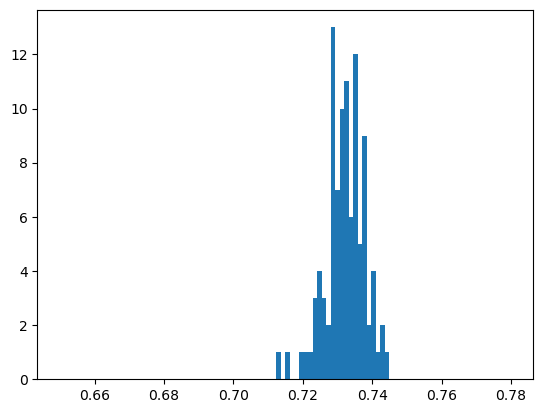

In [15]:
plt.hist(similarities_list, bins=100, range=[0.65, 0.78])

In [16]:
test_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds2")
len(test_dataset), len(my_dataset)

(12000, 70000)

In [17]:
similarities_test_list_1 = get_similarities(my_dataset_1, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 2., 2., 2., 4., 3., 7., 7., 4., 9., 5., 7., 5., 6., 8., 6.,
        4., 5., 5., 1., 3., 2., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.65  , 0.6513, 0.6526, 0.6539, 0.6552, 0.6565, 0.6578, 0.6591,
        0.6604, 0.6617, 0.663 , 0.6643, 0.6656, 0.6669, 0.6682, 0.6695,
        0.6708, 0.6721, 0.6734, 0.6747, 0.676 , 0.6773, 0.6786, 0.6799,
        0.6812, 0.6825, 0.6838, 0.6851, 0.6864, 0.6877, 0.689 , 0.6903,
        0.6916, 0.6929, 0.6942, 0.6955, 0.6968, 0.6981, 0.6994, 0.7007,
        0.702 , 0.7033, 0.7046, 0.7059, 0.7072, 0.7085, 0.7098, 0.7111,
        0.7124, 0.7137, 0.715 , 0.7163, 0.7176, 0.7189, 0.7202, 0.7215,
        0.7228, 0.7241, 0.7254, 0.7267, 0.728 

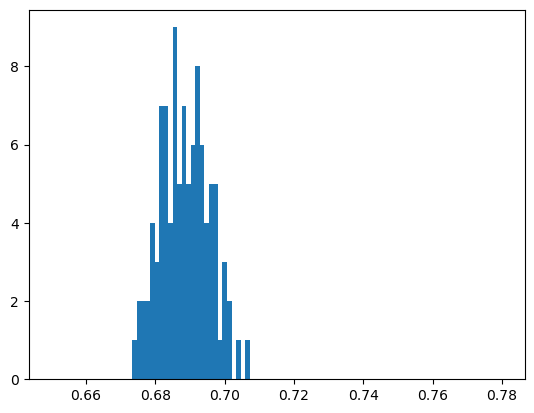

In [18]:
plt.hist(similarities_test_list_1, bins=100, range=[0.65, 0.78])

In [19]:
similarities_test_list_2 = get_similarities(my_dataset_2, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 0.,  0.,  1.,  4., 12., 44., 22., 17.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.65  , 0.6565, 0.663 , 0.6695, 0.676 , 0.6825, 0.689 , 0.6955,
        0.702 , 0.7085, 0.715 , 0.7215, 0.728 , 0.7345, 0.741 , 0.7475,
        0.754 , 0.7605, 0.767 , 0.7735, 0.78  ]),
 <BarContainer object of 20 artists>)

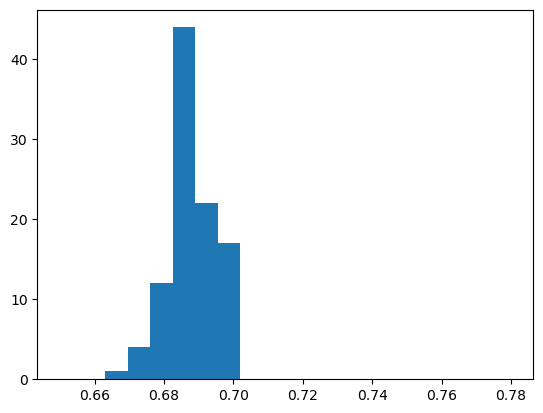

In [20]:
plt.hist(similarities_test_list_2, bins=20, range=[0.65, 0.78])

In [21]:
def plot_images(dataset, cnt, random_state=42):
    np.random.seed(random_state)

    idxs = np.random.choice(range(len(dataset)), cnt, replace=False)

    rows = int(np.ceil(cnt ** 0.5))
    cols = int(cnt ** 0.5)
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    for i, idx in enumerate(idxs):
        axs[i // cols, i % cols].imshow(dataset.get_original_image(idx))

    plt.show()

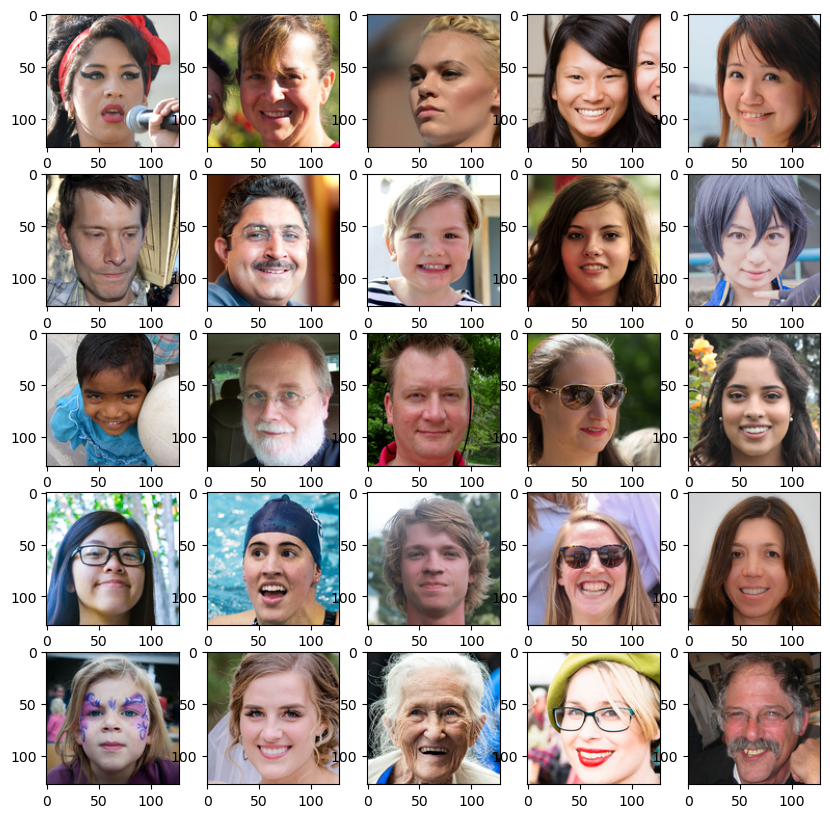

In [22]:
plot_images(my_dataset, 25)

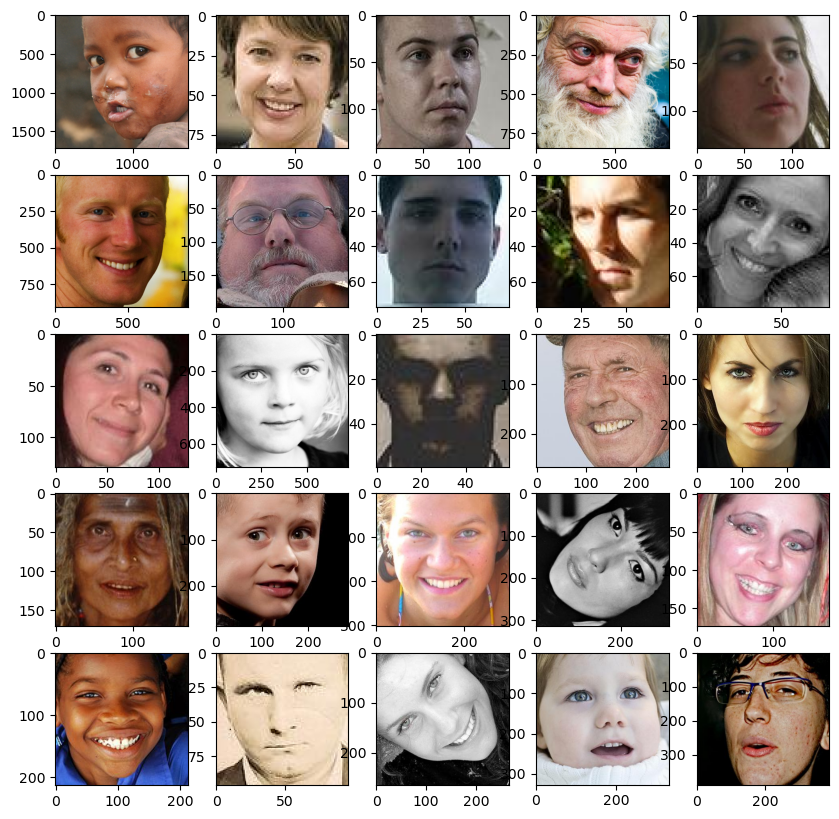

In [23]:
plot_images(test_dataset, 25)